# Static Embedding Analysis for EGU

In [135]:
from pathlib import Path
import os
import warnings
from collections import namedtuple

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [136]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [137]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [138]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'one_month_forecast'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'
# TARGET_VAR =      'VCI3M'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [139]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

### Load in the models

In [140]:
EXPERIMENT
# [d.name for d in (data_dir / 'models' / EXPERIMENT).iterdir()]

'one_month_forecast'

In [141]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

10

In [142]:
dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

static_vars_to_include = [
    v
    for v in static_ds.data_vars
    if all([ign_v not in v for ign_v in ealstm.ignore_vars])
]
static = static_ds[static_vars_to_include]

In [143]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

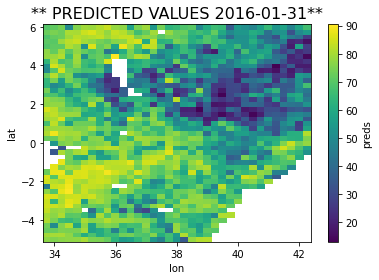

In [144]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Check the static data

In [145]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 23


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lon                                         (lon) float32 33.75 ... 42.25
  * lat                                         (lat) float32 -5.0 -4.75 ... 6.0
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

### Plot some of the aggregations

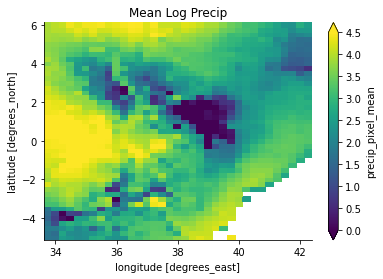

In [315]:
# global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

# fig, ax = plt.subplots()
# static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax, vmin=0, vmax=4.5, cmap='viridis')
ax.set_title("Mean Log Precip")
sns.despine()

# Model information

In [147]:
# print the model training features
ljust = 30

print(
    "", "MODEL NAME: ".ljust(ljust), f"{EXPERIMENT}\n",
    "Target Var: ".ljust(ljust), f"{TARGET_VAR}\n",
#     "Log y: ".ljust(ljust), f"{LOGY}\n",
    "Normalize y: ".ljust(ljust), f"{ealstm.normalize_y}\n",
    "Train Years: ".ljust(ljust), f"{ds['time.year'].min().values}: {y_train['time.year'].max().values}\n",
    "Test Years: ".ljust(ljust), f"{np.unique(y_test['time.year'])}\n",
#     "N Pixels: ".ljust(ljust), f"{len(df.station_id.unique())}\n",
    "Dynamic Variables: ".ljust(ljust), f"{[v for v in list(ds.data_vars) if v not in list(set(ealstm.ignore_vars))]}\n",
    "Static Variables: ".ljust(ljust), f"{[v for v in list(static_ds.data_vars) if all([i not in v for i in list(set(ealstm.ignore_vars))])]}\n", 
#     "Sequence Length: ".ljust(ljust), f"{ealstm.seq_length}\n", 
    "Final Linear Layer size: ".ljust(ljust), f"{ealstm.dense_features}\n", 
    "Static Embedding Size: ".ljust(ljust), f"{ealstm.static_embedding_size}\n", 
#     "Num Epochs: ".ljust(ljust), f"{N_EPOCHS}\n", 
#     "VAR: ".ljust(ljust), f"{VAR}\n", 
)

 MODEL NAME:                    one_month_forecast
 Target Var:                    boku_VCI
 Normalize y:                   True
 Train Years:                   2001: 2015
 Test Years:                    [2016 2017 2018]
 Dynamic Variables:             ['boku_VCI', 'precip', 'E', 'SMsurf', 'pev']
 Static Variables:              ['precip_global_mean', 'E_global_mean', 'SMsurf_global_mean', 'pev_global_mean', 'precip_pixel_mean', 'E_pixel_mean', 'SMsurf_pixel_mean', 'pev_pixel_mean', 'topography', 'lc_class', 'lc_class_group', 'cropland_rainfed_one_hot', 'herbaceous_cover_one_hot', 'tree_or_shrub_cover_one_hot', 'cropland_irrigated_or_postflooding_one_hot', 'tree_cover_one_hot', 'shrubland_one_hot', 'grassland_one_hot', 'urban_areas_one_hot', 'bare_areas_one_hot', 'water_bodies_one_hot', 'permanent_snow_and_ice_one_hot', 'slt']
 Final Linear Layer size:       [256, 1]
 Static Embedding Size:         64



# Get the embeddings

In [148]:
from scripts.drafts.static_embeddings import get_static_embedding, sort_by_another_list

In [149]:
# ------------------------------------------------
# KEY FUNCTION
# ------------------------------------------------

all_e, (all_static_x, all_latlons, all_pred_months) = get_static_embedding(ealstm)

Calling Training DataLoader
Current size of static data: 23


In [150]:
# REMOVE the samples which have more than one predicted timestep(/month) (wtf?!)
pred_months_err_mask = [len(np.unique(pm)) == 1 for pm in all_pred_months]
print("N Errors:", (~np.array(pred_months_err_mask)).sum())

# convert to numpy arrays and drop errors
all_e = np.array(all_e)[pred_months_err_mask]  #  type: ignore
all_static_x = np.array(all_static_x)[pred_months_err_mask]  #  type: ignore
all_pred_months = np.array(all_pred_months)[pred_months_err_mask]  #  type: ignore
all_latlons = np.array(all_latlons)[pred_months_err_mask]  #  type: ignore
    
assert all_latlons.shape == all_static_x.shape
assert all_pred_months.shape == all_e.shape
assert all([i == 1 for i in [len(np.unique(pm)) for pm in all_pred_months]]), "assert all timsteps have only 1 pred month"

N Errors: 0


In [151]:
# sort by the pred month
pred_months = [int(np.unique(pm)) for pm in all_pred_months]

all_e = sort_by_another_list(all_e, pred_months)
all_static_x = sort_by_another_list(all_static_x, pred_months)
all_latlons = sort_by_another_list(all_latlons, pred_months)
all_pred_months = sort_by_another_list(all_pred_months, pred_months)

pred_months = [int(np.unique(pm)) for pm in all_pred_months]
pred_months

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12]

In [152]:
n_pixels, counts = np.unique([e.shape[0] for e in all_e], return_counts=True)
CORRECT_N_PIXELS = sort_by_another_list(n_pixels, counts)[-1]
CORRECT_N_PIXELS

1404

In [153]:
# get only the values with the correct number of pixels (wtf?)
mask_missing_pixels = [ix for (ix, e) in enumerate(all_e) if e.shape[0] == CORRECT_N_PIXELS]

all_e = all_e[mask_missing_pixels]
all_static_x = all_static_x[mask_missing_pixels]
all_latlons = all_latlons[mask_missing_pixels]
all_pred_months = all_pred_months[mask_missing_pixels]
pred_months = [int(np.unique(pm)) for pm in all_pred_months]
pred_months

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12]

In [154]:
# check they are all the same
import calendar
# get the unique indexes of the months (from pred_months)
unique_ids = [pred_months.index(x) for x in set(pred_months)]

# check the first for that month against the others for that month
for id_1, id_2, month in zip(unique_ids, [id_ + 1 for id_ in unique_ids], set(pred_months)):
    mth = calendar.month_abbr[month]
    if all_e[id_1].shape == all_e[id_2].shape:
        print(f"1 {mth}: ", np.all(all_e[id_1] == all_e[id_2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 1].shape:
        print(f"2 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 1]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 2].shape:
        print(f"3 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 3].shape:
        print(f"4 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 3]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 4].shape:
        print(f"5 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 4]))
    else:
        print(f"# {mth}: UNABLE TO FIND matching shape")

1 Jan:  True
1 Feb:  True
1 Mar:  True
1 Apr:  True
1 May:  False
1 Jun:  True
1 Jul:  True
1 Aug:  True
1 Sep:  True
1 Oct:  True
1 Nov:  True
1 Dec:  True


In [155]:
# ### NOTE: MANUAL SELECTION PROCESS
 
# np.array([
#     np.array([(month, (ix, e.shape)) for (ix, (e, month)) in enumerate(zip(all_e, pred_months)) if month == i] )
#     for i in range(1, 13)
# ])

# unique_ids = [0, 13, 26, 40, 54, 69, 83, 96, 110, 124, 138, 152]

In [156]:
# Get only one static embedding for each month
unique_ids = [pred_months.index(x) for x in set(pred_months)]
month_embeddings = all_e[unique_ids]  # type: ignore

# check they are all the same size ...
assert all(np.isin(month_embeddings[0].shape, [e.shape for e in month_embeddings]))

month_static_x = all_static_x[unique_ids]  # type: ignore
month_latlons = all_latlons[unique_ids]  # type: ignore
month_pred_months = all_pred_months[unique_ids]  # type: ignore
month_pred_months = [np.unique(m)[0] for m in month_pred_months]

month_pred_months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Plot the Raw Embeddings

In [157]:
def plot_embedding(embedding, ax):
    img = ax.pcolor(embedding.T, cmap='plasma')
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Input gate neuron")
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Activation")
    return ax

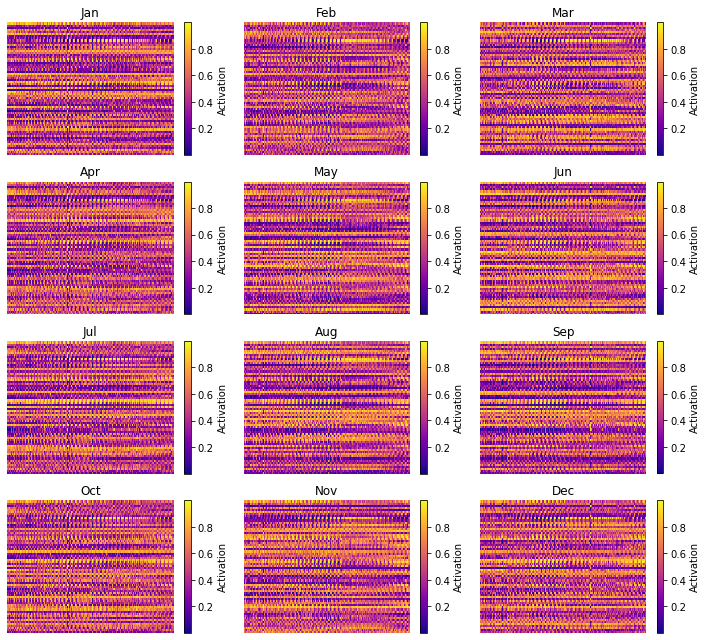

In [158]:
fig, axs = plt.subplots(4, 3, figsize=(10, 3*3))

for ix, (embedding, pred_month) in enumerate(zip(month_embeddings, month_pred_months)):
    ax = axs[np.unravel_index(ix, (4, 3))]
    img = ax.pcolor(embedding.T, cmap='plasma')
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Input gate neuron")
    month = [m for m in calendar.month_abbr][pred_month]
    ax.set_title(f"{month}")
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Activation")
    ax.axis('off')
    
fig.tight_layout()

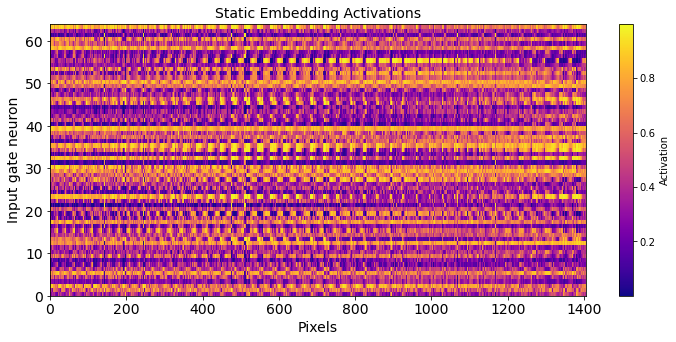

In [159]:
embedding = month_embeddings[0]

fig, ax = plt.subplots(figsize=(12, 5))
plot_embedding(embedding, ax=ax)
ax.set_title('Static Embedding Activations')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

# Run the Clustering

In [160]:
from scripts.drafts.static_embeddings import run_clustering, get_regions_for_clustering_boxes

In [161]:
ks = [3, 4, 5]

cluster_ds, estimators = run_clustering(
    month_embeddings=month_embeddings,
    month_pred_months=month_pred_months,
    month_latlons=month_latlons,
    ks=ks,
)

12it [01:38,  8.19s/it]


In [162]:
cluster_ds = cluster_ds.sortby('lat').sortby('lon')

In [163]:
regions = get_regions_for_clustering_boxes(cluster_ds)
print(regions)

# assert len(regions) == 4

[Region(name='coastal', lonmin=array(37.5), lonmax=array(38.75), latmin=array(-4.75), latmax=array(-2.25)), Region(name='victoria', lonmin=array(33.75), lonmax=array(35.5), latmin=array(-0.75), latmax=array(1.75)), Region(name='turkana', lonmin=array(35.), lonmax=array(37.75), latmin=array(2.25), latmax=array(4.75)), Region(name='southern_highlands', lonmin=array(34.5), lonmax=array(37.), latmin=array(-4.), latmax=array(-1.5)), Region(name='nw_pastoral', lonmin=array(33.75), lonmax=array(36.75), latmin=array(4.75), latmax=array(6.))]


# Choosing k
- Check the silhouette score

### Silhouette Score
$\frac{(b - a)}{max(a, b)}$
- $a$ = mean intra-cluster distance
- $b$ = the mean nearest-cluster distance
- $b$ is the distance between a sample and the nearest cluster that the sample is not a part of
- The best value is 1 and the worst value is -1. 
- Values near 0 indicate overlapping clusters. 
- Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
- Silhouette values measure within-cluster sim- ilarity and range between [−1, 1], with positive values indi- cating a high degree of separation between clusters and neg- ative values indicating a low degree of separation between clusters. 
- "embedding layer provides more distinct catchment clus- ters than when clustering by the raw catchment attributes"
- Shows us **How distinct are clusters of pixels?**

In [164]:
from sklearn.metrics import silhouette_score

In [165]:
# estimators[0][5]

In [166]:
k = [3, 4, 5]

k_dfs = []

for k in ks:
    scores = []
    for month in range(12):
        score = silhouette_score(
            month_embeddings[month], 
            estimators[month][k].labels_, 
            metric='euclidean', 
            sample_size=300
        )
        mth = calendar.month_abbr[month + 1]
        # print(f"{mth}: {score:.2f}")
        scores.append(score)
    
    d = pd.DataFrame({f"{k}": scores}, index=range(12))
    k_dfs.append(d)
    
k_df = pd.concat(k_dfs, axis=1)

In [167]:
k_df

,3,4,5
0,0.222521,0.196622,0.190776
1,0.276235,0.186784,0.198834
2,0.230447,0.191811,0.207943
3,0.234344,0.175736,0.202945
4,0.222355,0.191416,0.193208
5,0.231473,0.202719,0.212802
6,0.217057,0.194656,0.189778
7,0.265120,0.182779,0.171313
8,0.231083,0.194129,0.170247
9,0.199615,0.193252,0.186789


### Plot space reduce to 2D

In [168]:
from sklearn.decomposition import PCA

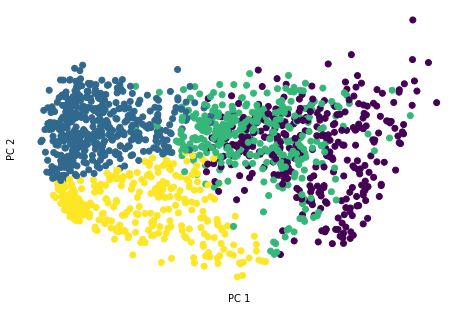

In [169]:
scale = 1.3

fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

# collapse to 2 dimensions using PCA
reduced_data = PCA(n_components=2).fit_transform(month_embeddings.mean(axis=0))
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=estimators[month][4].labels_)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_xticklabels([''])
ax.set_xticks([])
ax.set_yticklabels([''])
ax.set_yticks([])

for k, v in ax.spines.items():
    v.set_visible(False)

# ax.legend()
# ax.axis('off');

In [170]:
###

In [171]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Interesting approach for selecting / visualising 
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
- measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.
- near +1 indicate that the sample is far away from the neighboring
- 

In [172]:
month_embeddings.mean().shape

(1404, 64)

In [173]:
import matplotlib.cm as cm


def run_multiple_cluster_comparisons(X):
    """
    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    """
    range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2880767387721346
For n_clusters = 3 The average silhouette_score is : 0.220134082886077
For n_clusters = 4 The average silhouette_score is : 0.19332944085064976
For n_clusters = 5 The average silhouette_score is : 0.1898374035338045
For n_clusters = 6 The average silhouette_score is : 0.20015251955551905


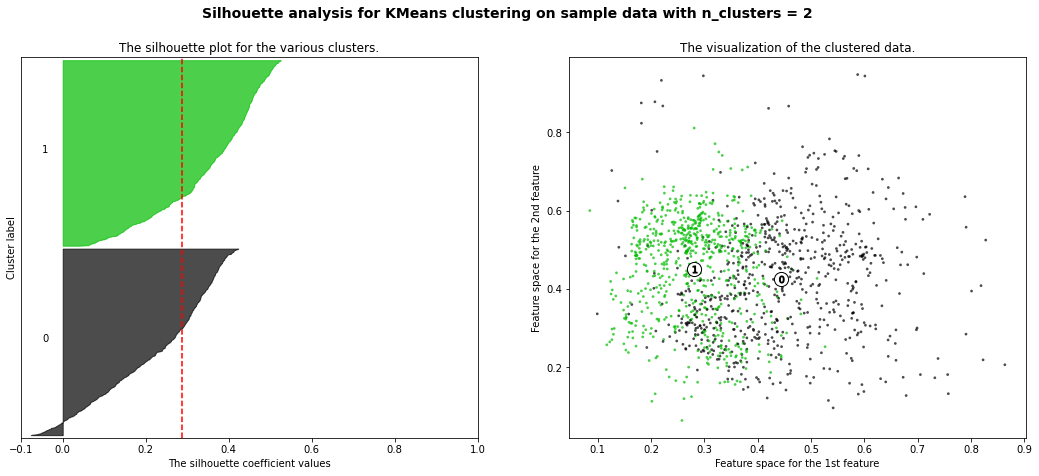

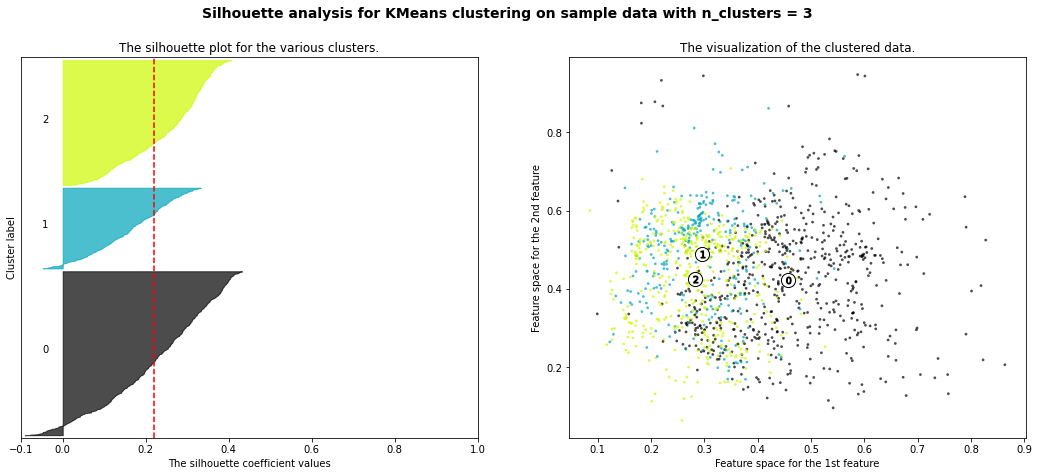

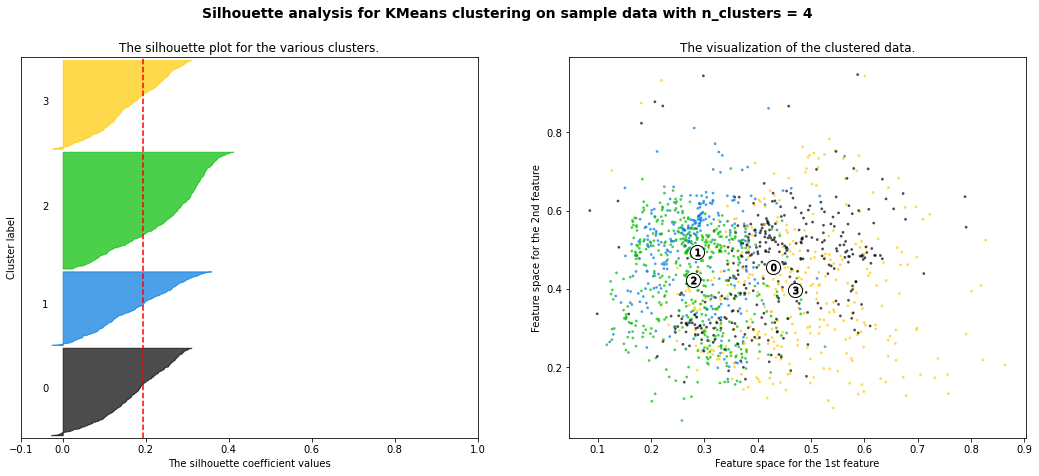

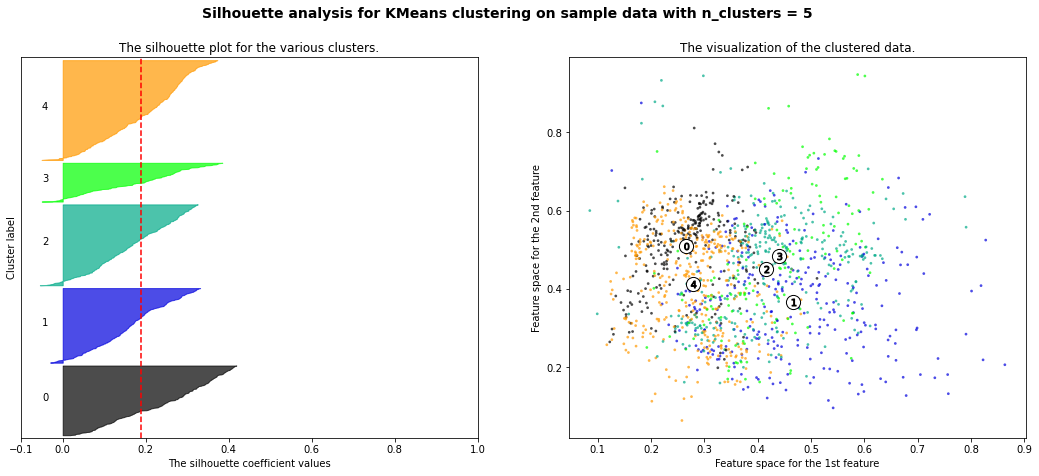

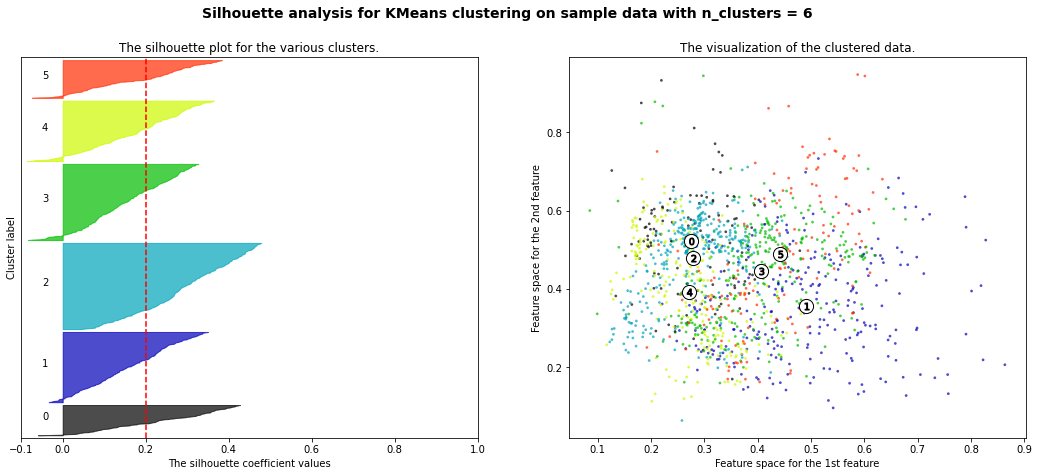

In [174]:
X = month_embeddings.mean()

run_multiple_cluster_comparisons(X)

For n_clusters = 2 The average silhouette_score is : 0.2725408691225157
For n_clusters = 3 The average silhouette_score is : 0.22671178555814894
For n_clusters = 4 The average silhouette_score is : 0.22662994261051567
For n_clusters = 5 The average silhouette_score is : 0.23352550701903682
For n_clusters = 6 The average silhouette_score is : 0.20579886611379442


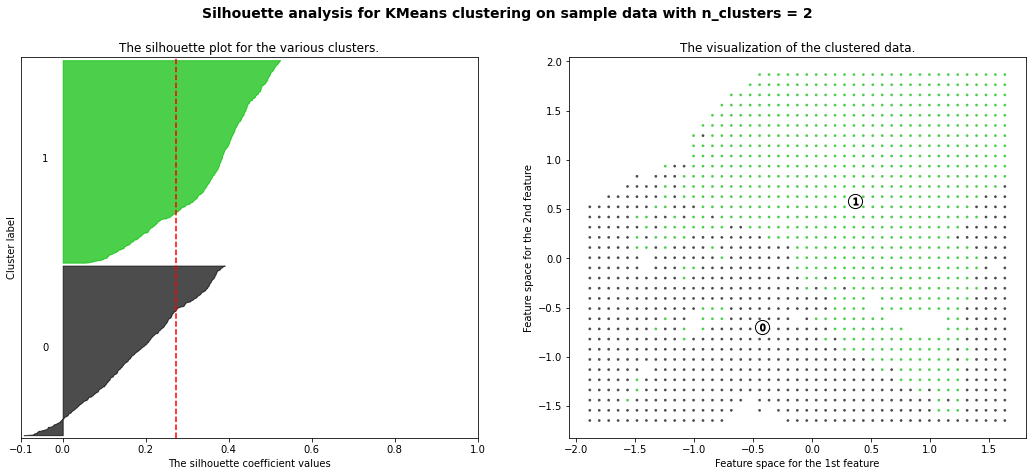

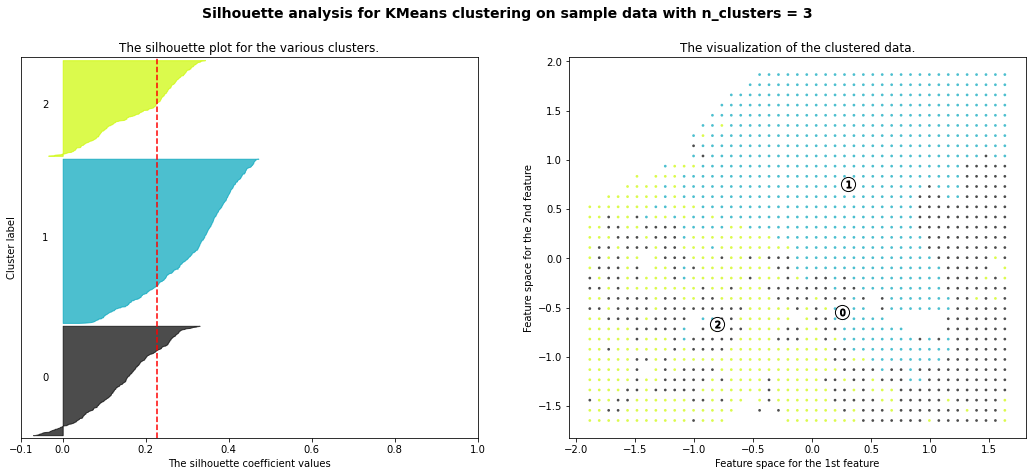

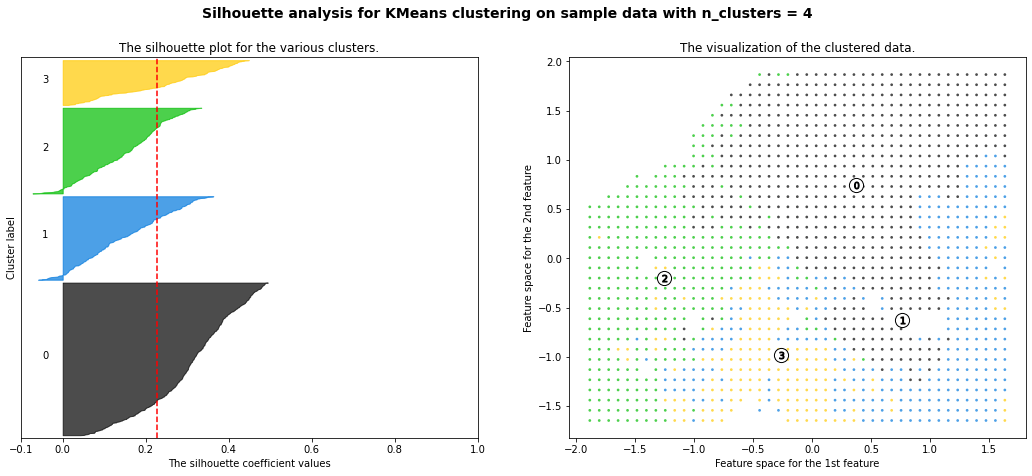

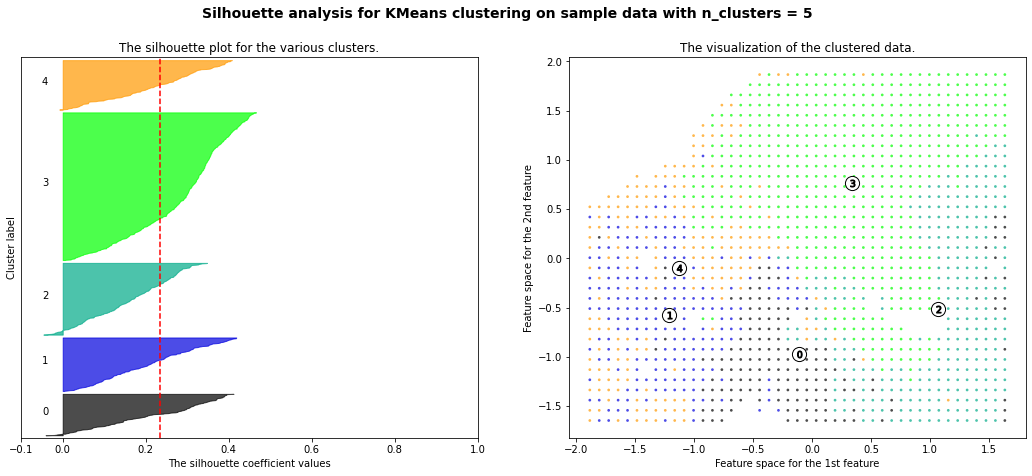

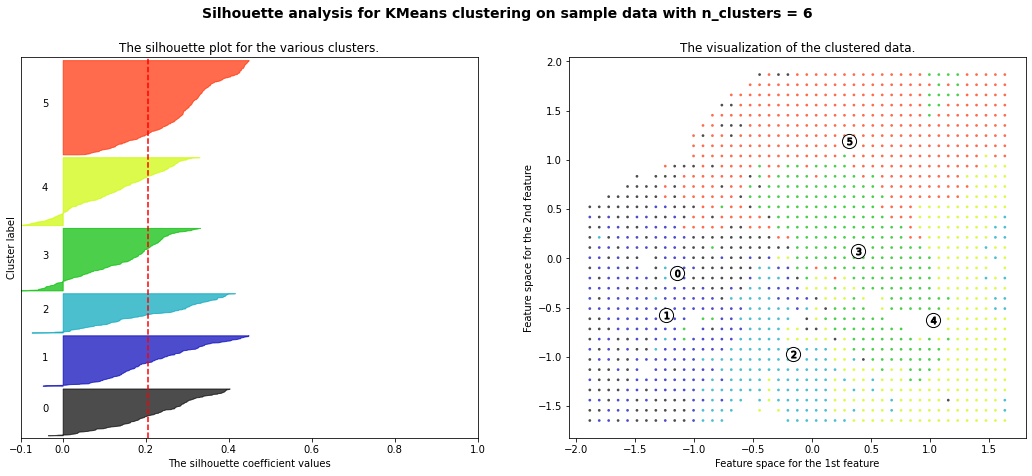

In [175]:
X = month_static_x.mean()

run_multiple_cluster_comparisons(X)

# Shapefile processes

In [176]:
import geopandas as gpd

### Get the outline of Kenya

In [177]:
# if (data_dir / "tommy/kenya_gdf.pkl").exists():
#     kenya = pickle.load(open(data_dir / "tommy/kenya_gdf.pkl", 'rb'))
# else:
#     gdf = gpd.read_file(data_dir / 'raw/boundaries/kenya/Admin2/KEN_admin2_2002_DEPHA.shp')
#     gdf['country'] = ['kenya' for i in range(len(gdf))]
#     display(gdf.head())
#     gdf.plot()

#     kenya = gdf.dissolve(by='country').drop(columns=['PROVINCE', 'Prov_Pcode'])
#     pickle.dump(kenya, open(data_dir / "tommy/kenya_gdf.pkl", 'wb'))

# kenya.plot()

### Get boundaries in Africa

In [178]:
gdf = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
africa = gdf.query("continent == 'Africa'")

### chop out Kenya

In [179]:
kenya = gdf.query("name == 'Kenya'")

In [180]:
from scripts.drafts.mask_using_shapefile import rasterize

In [181]:
shapes = [(shape, n) for n, shape in enumerate(kenya.geometry)]
xr_da = cluster_ds.cluster_5

In [182]:
kenya_xr = rasterize(
    shapes, xr_da.coords, longitude='lon', latitude='lat'
)
kenya_mask = np.isnan(kenya_xr)

# remap the matching groups
- becuase of the random initialisation of kmeans
- need some method for matching the different clusters to semantic labels. 
- Currently the labels mean nothing

In [183]:
from scripts.drafts.static_embeddings import get_matching_groups, plot_comparisons
from matplotlib import cm
from matplotlib.colors import ListedColormap


n_unique_vals = 4
colors = cm.get_cmap('viridis', n_unique_vals)(np.linspace(0, 1, n_unique_vals))
# colors = np.array(["#fde832", "#67c962", "#43928d", "#3b528b", "#461954"])
cmap = ListedColormap(colors)

In [184]:
# check it's worked
comparison_da = cluster_ds.isel(time=4).cluster_4
reference_da = cluster_ds.isel(time=0).cluster_4

remap_dict, df = get_matching_groups(reference_da, comparison_da, regions=regions)

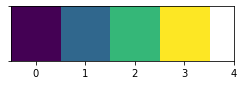

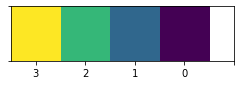

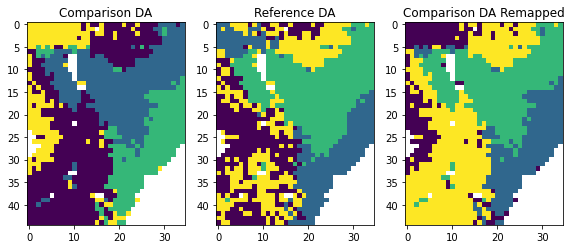

In [185]:
plot_comparisons(
    reference_da,
    comparison_da,
    colors=colors,
    remapping_dict=remap_dict,
    title=None,
)

## remapping using colormaps

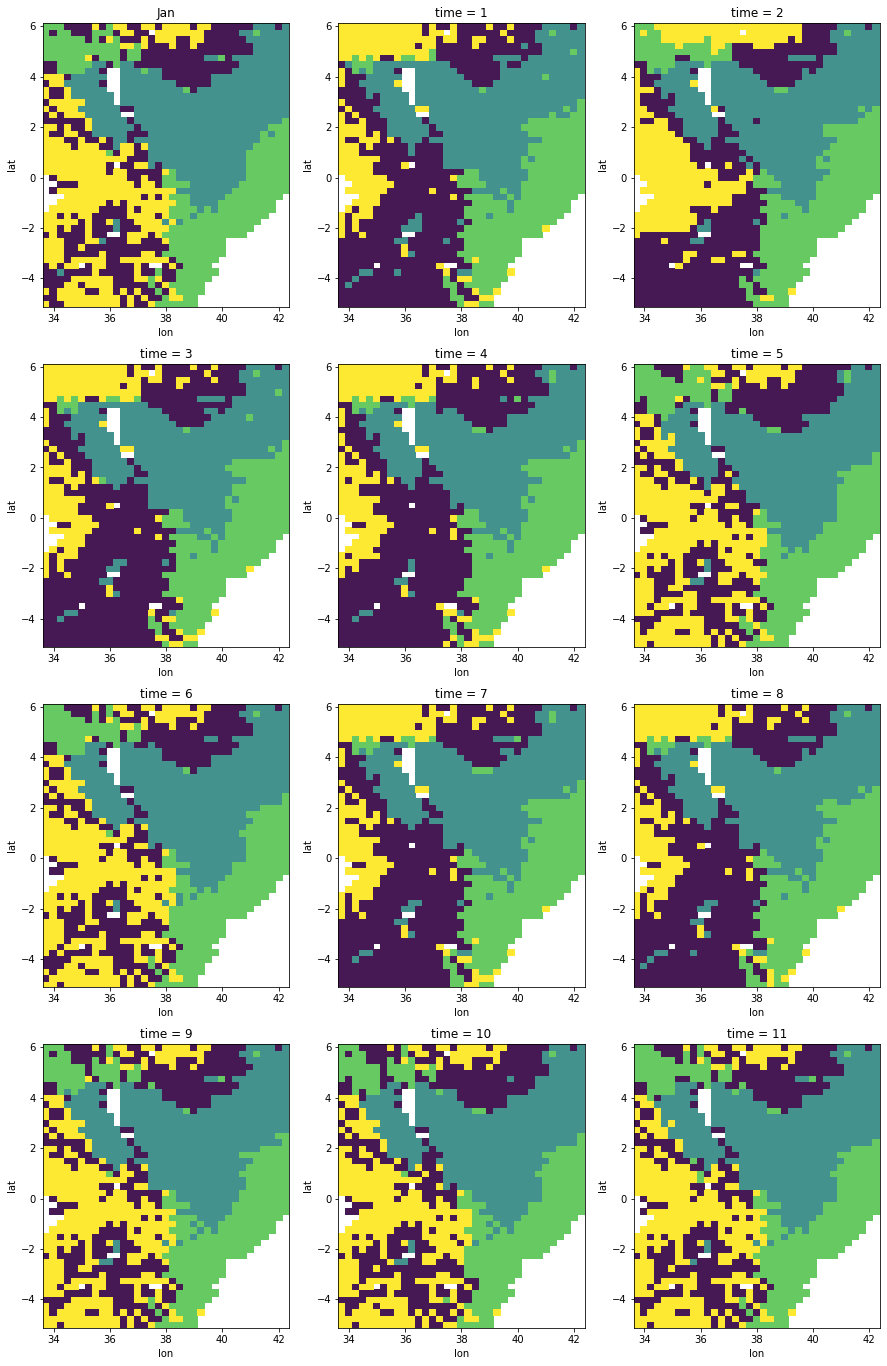

In [186]:
k = 4

# Are the remappings working?

fig, axs = plt.subplots(4, 3, figsize=(15, 8*3))
colors = np.array(["#fde832", "#67c962", "#43928d", "#3b528b", "#461954"])
colors = np.array(["#fde832", "#67c962", "#43928d", "#461954"])
cmap = ListedColormap(colors)

reference_da.plot(
    ax=axs[0, 0], add_colorbar=False, cmap=cmap
)
axs[0, 0].set_title(calendar.month_abbr[1])

remap_dicts = {}

new_cmaps = []
for mth in range(1, 12):
    ax = axs[np.unravel_index(mth, (4, 3))]
    comparison_da = cluster_ds.isel(time=mth)[f"cluster_{k}"]
    remap_dict, matches_df = get_matching_groups(reference_da, comparison_da, regions=regions)
    new_cmap = ListedColormap(colors[np.array([int(i) for i in remap_dict.values()])])

    comparison_da.plot(
        add_colorbar=False, ax=ax, cmap=new_cmap
    )

    remap_dicts[calendar.month_abbr[mth+1]] = remap_dict
    new_cmaps.append(new_cmap)

# Remap the values to the same group values (0-5)

In [187]:
from scripts.drafts.static_embeddings import remap_all_monthly_values

In [188]:
remap_dicts

{'Feb': {0.0: 2.0, 1.0: 3.0, 2.0: 0.0, 3.0: 1.0},
 'Mar': {0.0: 2.0, 1.0: 3.0, 2.0: 0.0, 3.0: 1.0},
 'Apr': {0.0: 3.0, 1.0: 1.0, 2.0: 2.0, 3.0: 0.0},
 'May': {0.0: 3.0, 1.0: 2.0, 2.0: 1.0, 3.0: 0.0},
 'Jun': {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0},
 'Jul': {0.0: 0.0, 1.0: 2.0, 2.0: 3.0, 3.0: 1.0},
 'Aug': {0.0: 0.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0},
 'Sep': {0.0: 0.0, 1.0: 3.0, 2.0: 2.0, 3.0: 1.0},
 'Oct': {0.0: 0.0, 1.0: 2.0, 2.0: 3.0, 3.0: 1.0},
 'Nov': {0.0: 2.0, 1.0: 0.0, 2.0: 3.0, 3.0: 1.0},
 'Dec': {0.0: 0.0, 1.0: 2.0, 2.0: 3.0, 3.0: 1.0}}

In [189]:
remapped_ds = remap_all_monthly_values(cluster_ds, remap_dicts)



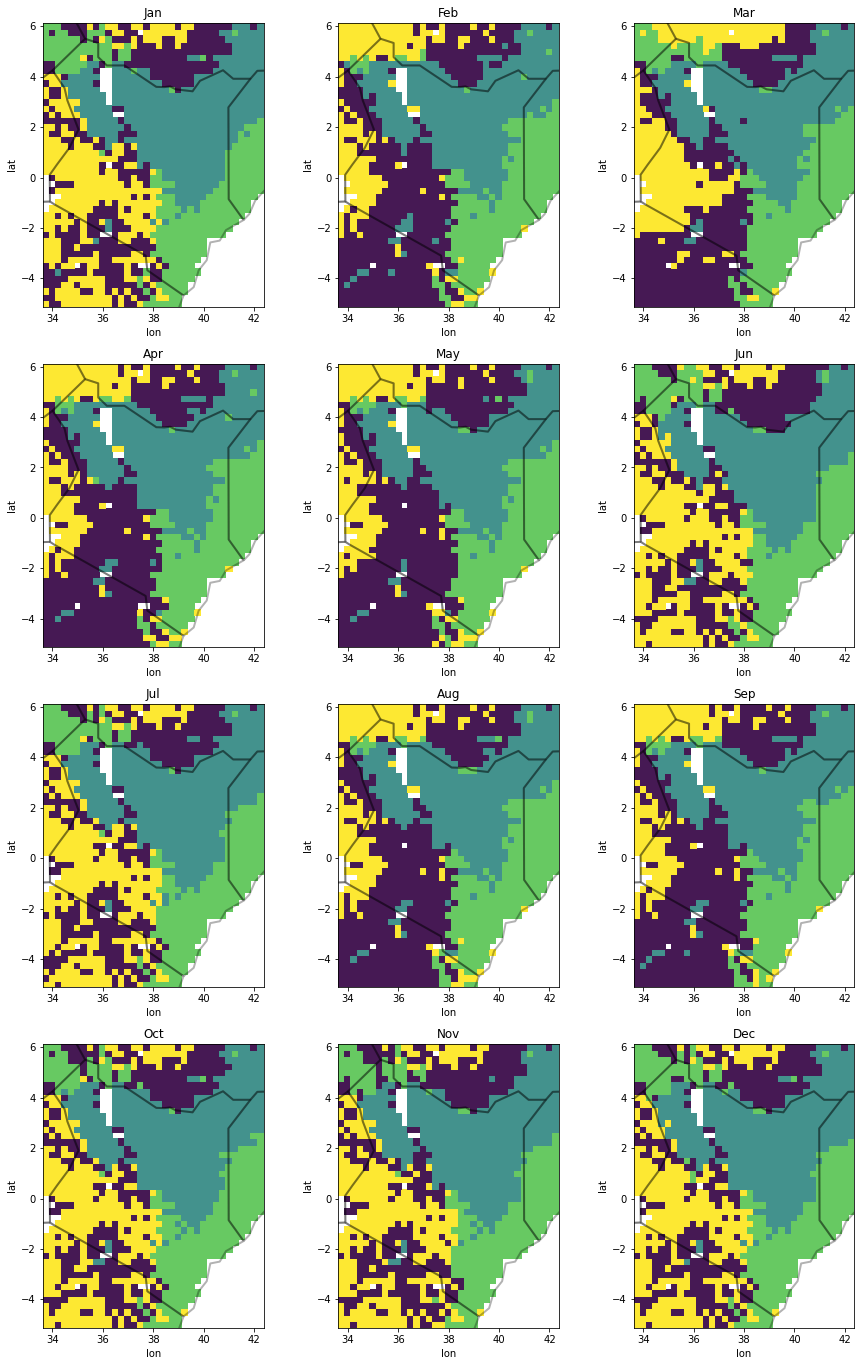

In [190]:
# plot each month with same colormap
fig, axs = plt.subplots(4, 3, figsize=(15, 8*3))

cmap = ListedColormap(colors)

for mth in range(0, 12):
    ax = axs[np.unravel_index(mth, (4, 3))]
    remapped_ds.cluster_4.isel(time=mth).plot(
        add_colorbar=False, ax=ax, cmap=cmap
    )
    ax.set_title(calendar.month_abbr[mth+1])
    africa.plot(facecolor='none', edgecolor='k', lw=2, alpha=0.3, ax=ax)


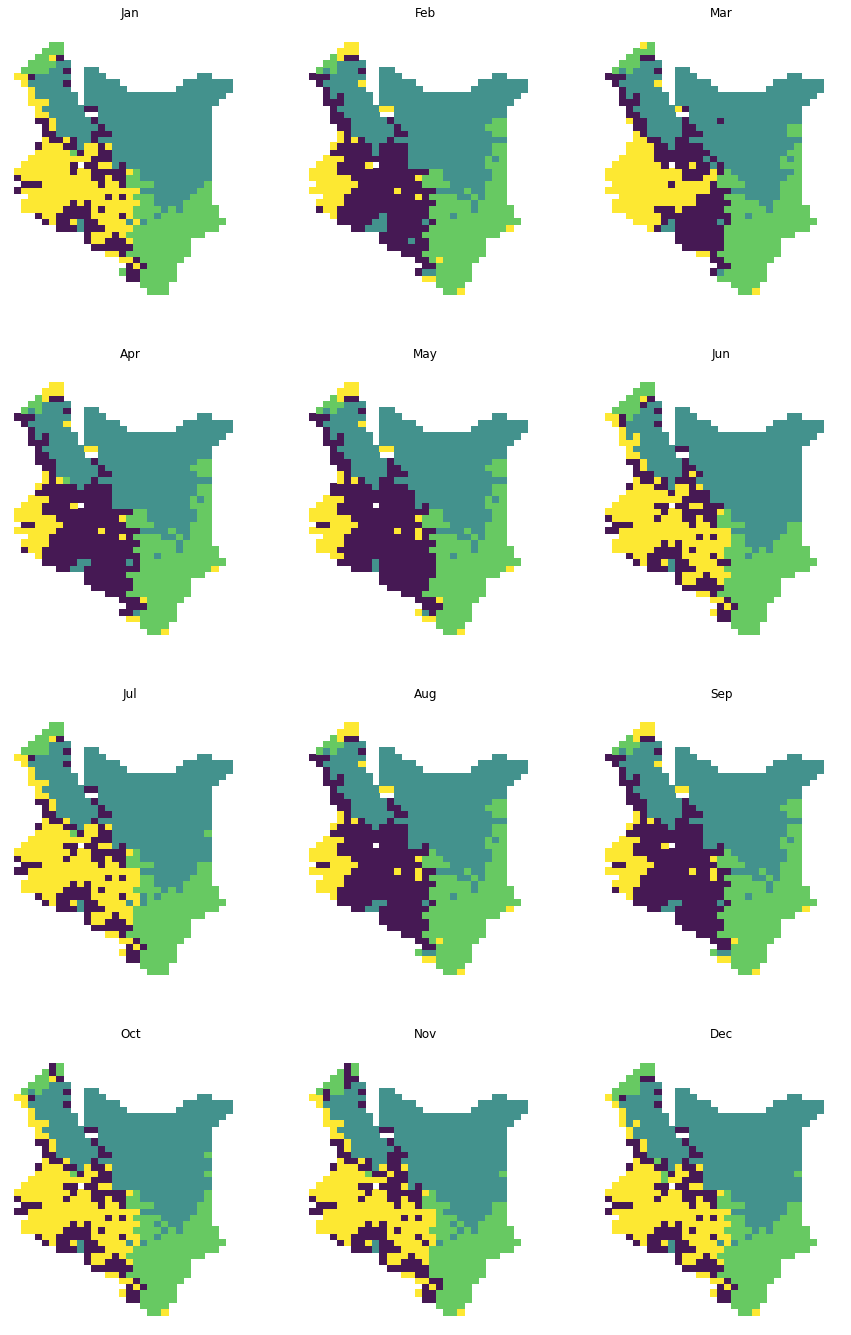

In [191]:
# plot each month with same colormap
fig, axs = plt.subplots(4, 3, figsize=(15, 8*3))

cmap = ListedColormap(colors)

for mth in range(0, 12):
    ax = axs[np.unravel_index(mth, (4, 3))]
    remapped_ds.cluster_4.isel(time=mth).where(~kenya_mask).plot(
        add_colorbar=False, ax=ax, cmap=cmap
    )
    ax.set_title(calendar.month_abbr[mth+1])
    ax.axis('off')


# Get modal across month

In [192]:
from src.utils import get_modal_value_across_time

In [193]:
cluster_da = get_modal_value_across_time(remapped_ds.cluster_4)

Extracting the data to numpy array
calculating the mode across the time dimension


Text(0.5, 1.0, 'Static Embedding: Modal Cluster Values')

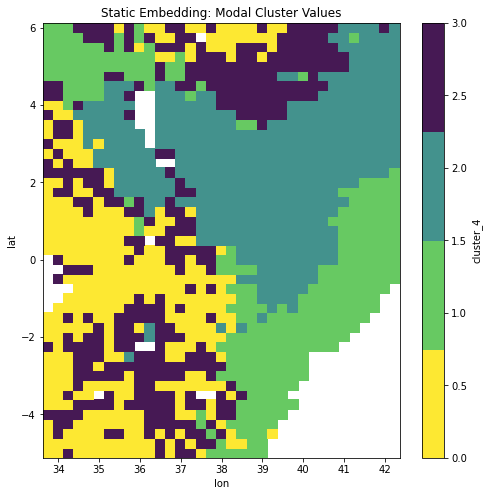

In [194]:
fig, ax = plt.subplots(figsize=(8, 8))
cmap = ListedColormap(colors)

remapped_ds.cluster_4.isel(time=mth).plot(
     add_colorbar=True, ax=ax, cmap=cmap
)
ax.set_title('Static Embedding: Modal Cluster Values')

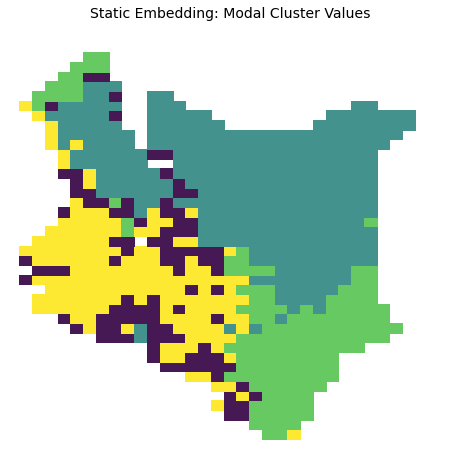

In [195]:
fig, ax = plt.subplots(figsize=(8, 8))
cmap = ListedColormap(colors)

remapped_ds.cluster_4.isel(time=mth).where(~kenya_mask).plot(
    add_colorbar=False, ax=ax, cmap=cmap
)
ax.set_title('Static Embedding: Modal Cluster Values')
ax.axis('off')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

In [196]:
region = [r for r in regions if r.name == 'victoria'][0]

# How do the dynamic variables vary across these clusters

In [197]:
# create a mask the same shape as the underlying data (n_times)
from src.utils import create_shape_aligned_climatology

da_clusters = cluster_ds['cluster_4']

da_c = da_clusters.to_dataset(name='precip').rename(dict(time='month'))
da_c['month'] = da_c['month'] + 1
cluster_mask = create_shape_aligned_climatology(dynamic_ds, clim=da_c, variable='precip', time_period='month')
cluster_mask = cluster_mask.rename(dict(precip='cluster_4'))
cluster_mask = cluster_mask['cluster_4']

In [219]:
# region_codes = dict(
#     victoria=3,
#     turkana=2,
#     coastal=1,
#     semi_arid=0,
#     humid=4,
# )
# region_codes = dict(
#     victoria=3,
#     turkana=0,
#     coastal=2,
# #     semi_arid=0,
#     highland=1,
# )
region_codes = dict(
    victoria=0,
    turkana=2,
    coastal=1,
#     semi_arid=0,
    southern_highlands=3,
)
# region_codes = dict(zip(region_codes.values(), region_codes.keys()))

region_codes

{'victoria': 0, 'turkana': 2, 'coastal': 1, 'southern_highlands': 3}

In [220]:
r_cols = colors[[i for i in region_codes.values()]]
region_colors = dict(zip(region_codes.keys(), r_cols))
region_colors

{'victoria': '#fde832',
 'turkana': '#43928d',
 'coastal': '#67c962',
 'southern_highlands': '#461954'}

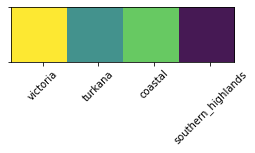

In [306]:
sns.palplot([c for c in region_colors.values()])
ax = plt.gca()
ax.set_xticks(np.linspace(0.07, 3.07, 4))
ax.set_xticklabels([c for c in region_colors.keys()], rotation=45);

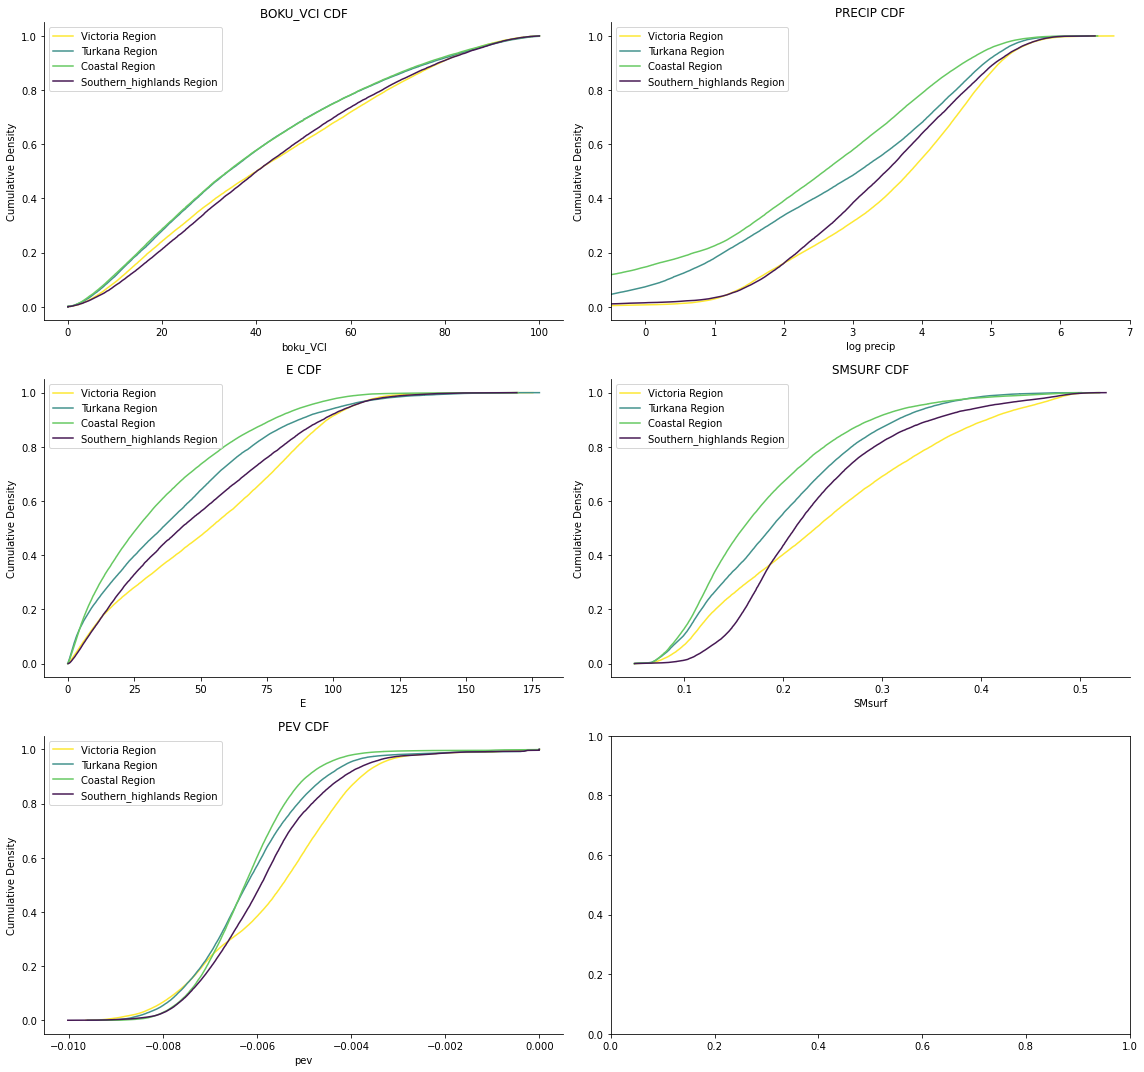

In [307]:
def plot_cdf(data: np.array, ax: Optional[plt.Axes] = None, **kwargs):
    """plot the sorted_data array against the number 
    of items smaller than each element in the array

    # https://stackoverflow.com/a/24576863/9940782
    """
    sorted_data = np.sort(data)
    
    # compute the 
    yvals = np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sorted_data, yvals, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
    return ax


#
dynamic_ds = dynamic_ds.drop('month') if 'month' in list(dynamic_ds.data_vars) else dynamic_ds
n_rows = (len(list(dynamic_ds.data_vars)) // 2) + (len(list(dynamic_ds.data_vars)) % 2)
fig, axs = plt.subplots(n_rows, 2, figsize=(8*2, 5*n_rows))

for ix, variable in enumerate(list(dynamic_ds.data_vars)):
    ax = axs[np.unravel_index(ix, (n_rows, 2))]
    
    if variable == 'precip':
        ax.set_xlim(-0.5, 7)

    for region in [n for n in region_codes.keys()]:
        # Extract the pixels from those regions 
        # data = a 1D array of the values from ds (no-nans)
        data = drop_nans_and_flatten(
            dynamic_ds
            .where(
                cluster_mask == region_codes[region]
            ).where(
                ~kenya_mask
            )[variable]
        )

        # plot cdf of the variable in that cluster
        ax = plot_cdf(
            data, ax=ax, 
            **dict(color=region_colors[region], label=f'{region.capitalize()} Region')
        )
        ax.set_xlabel(variable if variable != "precip" else f"log {variable}")
        ax.set_ylabel('Cumulative Density')
        ax.set_title(f'{variable.upper()} CDF')

plt.tight_layout()

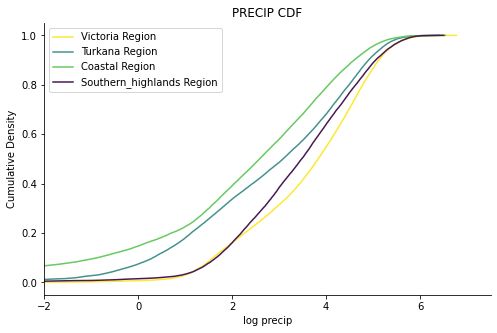

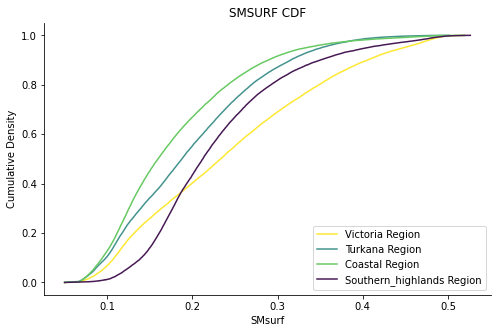

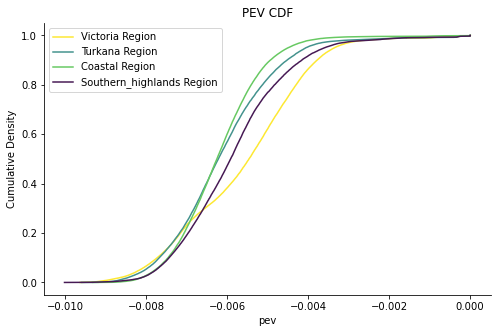

In [308]:
for ix, variable in enumerate(["precip", "SMsurf", "pev"]):
    fig, ax = plt.subplots(figsize=(8, 5))

    for region in [n for n in region_codes.keys()]:
        # Extract the pixels from those regions 
        # data = a 1D array of the values from ds (no-nans)
        data = drop_nans_and_flatten(
            dynamic_ds
            .where(
                cluster_mask == region_codes[region]
            ).where(
                ~kenya_mask
            )[variable]
        )
        if variable == "precip":
#             data = np.log(data + 0.0001)
            ax.set_xlim(-2, 7.5)

        # plot cdf of the variable in that cluster
        ax = plot_cdf(
            data, ax=ax, 
            **dict(color=region_colors[region], label=f'{region.capitalize()} Region')
        )
        ax.set_xlabel(variable if variable != "precip" else f"log {variable}")
        ax.set_ylabel('Cumulative Density')
        ax.set_title(f'{variable.upper()} CDF')


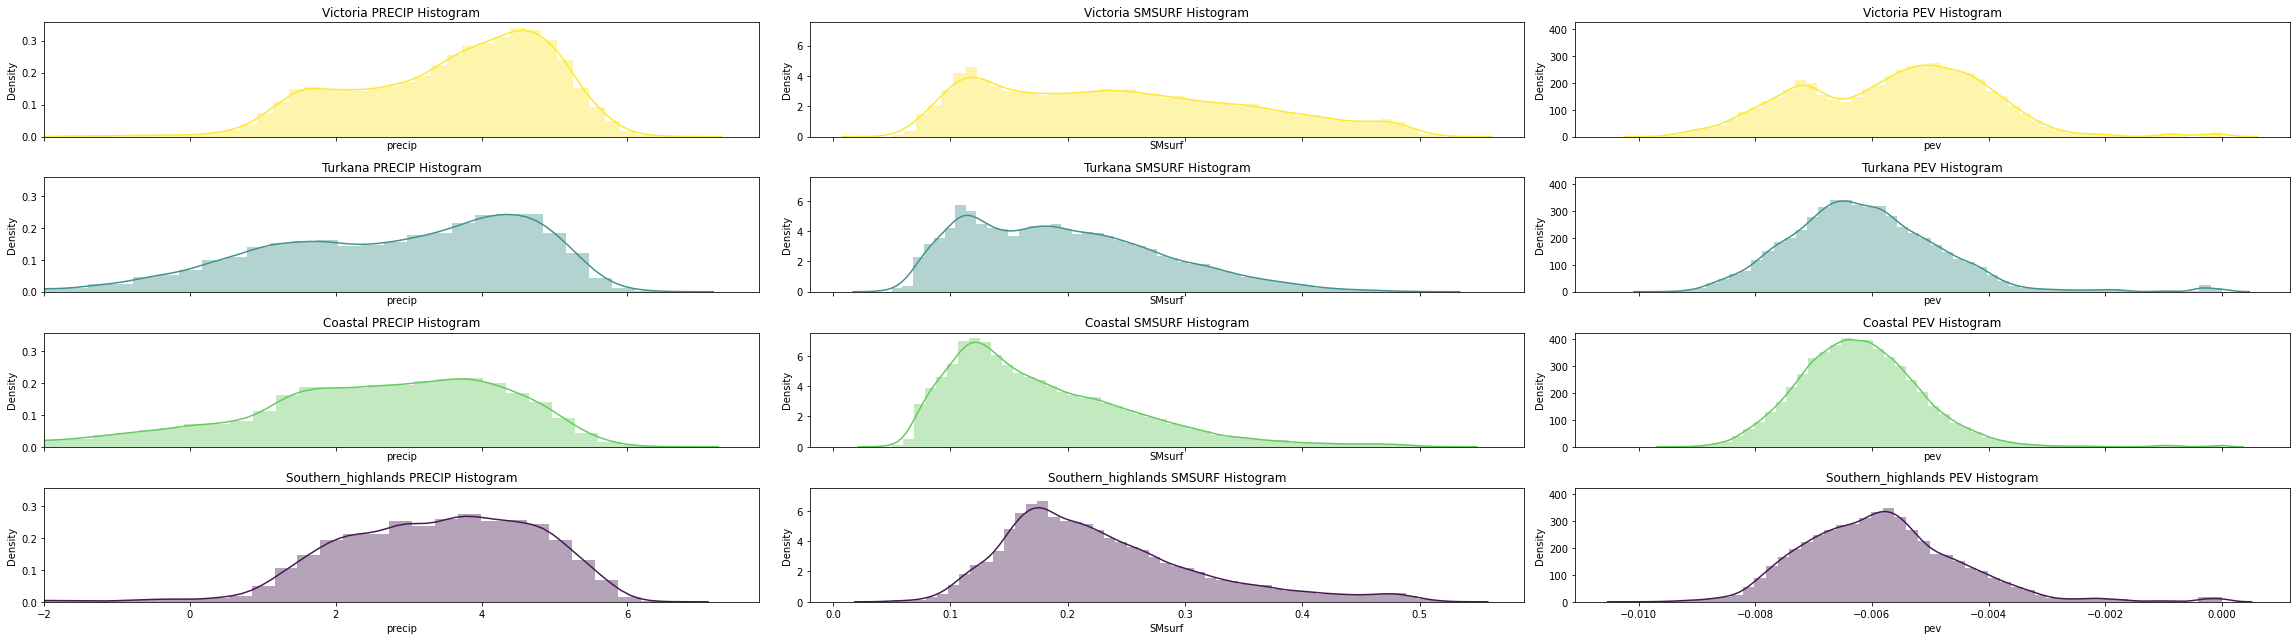

In [309]:
n_regions = len([n for n in region_codes.keys()])
fig, axs = plt.subplots(n_regions, 3, figsize=(8*n_regions, 3*3), sharex='col', sharey='col')

for ix, variable in enumerate(["precip", "SMsurf", "pev"]):
    for r_ix, region in enumerate([n for n in region_codes.keys()]):
        ax = axs[r_ix, ix]
        # Extract the pixels from those regions 
        # data = a 1D array of the values from ds (no-nans)
        data = drop_nans_and_flatten(
            dynamic_ds
            .where(
                cluster_mask == region_codes[region]
            ).where(
                ~kenya_mask
            )[variable]
        )
        if variable == "precip":
            data = np.log(data + 0.0001) if TARGET_VAR == "VCI3M" else data
            ax.set_xlabel("Log precip")
            ax.set_xlim(-2, 7.8)

        # plot cdf of the variable in that cluster
        sns.distplot(data, ax=ax, color=region_colors[region], label=f'{region.capitalize()} Region')
        ax.set_xlabel(variable)
        ax.set_ylabel('Density')
        ax.set_title(f'{region.capitalize()} {variable.upper()} Histogram')

plt.tight_layout()

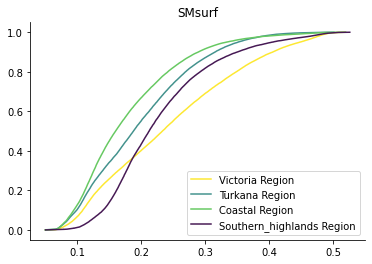

In [310]:
fig, ax = plt.subplots()
for region in [n for n in region_codes.keys()]:
    # data = a 1D array of the values from ds (no-nans)
    data = drop_nans_and_flatten(
        ds
        .where(
            cluster_mask == region_codes[region]
        ).where(
            ~kenya_mask
        )["SMsurf"]
    )

    # plot cdf of the variable in that cluster
    ax = plot_cdf(
        data, ax=ax, 
        **dict(color=region_colors[region], label=f'{region.capitalize()} Region')
    )
    ax.set_title("SMsurf")

### Explore the input variables

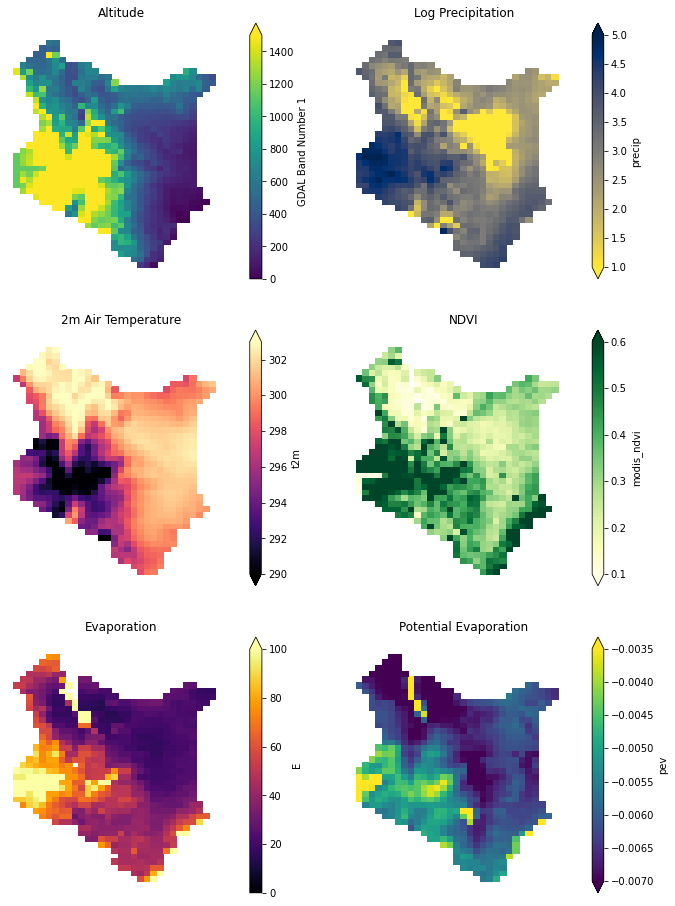

In [225]:
# Explore spatial patterns of variables
fig, axs = plt.subplots(3, 2, figsize=(3.75*3, 8*2))
static_ds.where(~kenya_mask).topography.plot(vmin=0, vmax=1500, ax=axs[0,0], cmap='viridis')
axs[0,0].set_title('Altitude')

ds.precip.where(~kenya_mask).mean(dim='time').plot(ax=axs[0,1], vmin=1, vmax=5, cmap='cividis_r')
axs[0,1].set_title('Log Precipitation')

ds.t2m.where(~kenya_mask).mean(dim='time').plot(ax=axs[1,0], vmin=290, vmax=303, cmap='magma')
axs[1,0].set_title('2m Air Temperature')

ds.modis_ndvi.where(~kenya_mask).mean(dim='time').plot(ax=axs[1,1], vmin=0.1, vmax=0.6, cmap='YlGn')
axs[1,1].set_title('NDVI')

ds.E.where(~kenya_mask).mean(dim='time').plot(ax=axs[2,0], vmin=0, vmax=100, cmap='inferno')
axs[2,0].set_title('Evaporation')

(
    ds.pev.mean(dim='time')
#     static_ds.cropland_irrigated_or_postflooding_one_hot + static_ds.cropland_rainfed_one_hot
).where(~kenya_mask).plot(vmin=-0.007, vmax=-0.0035, ax=axs[2,1], cmap='viridis')
axs[2,1].set_title('Potential Evaporation')

for ax in axs.flatten():
    ax.axis('off')

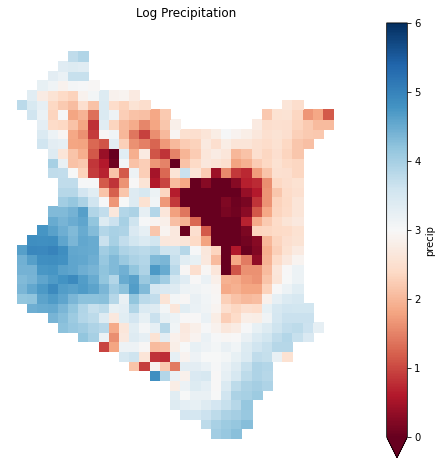

In [226]:
fig, ax = plt.subplots(figsize=(8, 8))

dynamic_ds['precip'].mean(dim='time').where(~kenya_mask).plot(ax=ax, cmap="RdBu", vmin=0, vmax=6)
ax.set_title("Log Precipitation")
ax.axis('off');

In [227]:
remapped_ds.cluster_4.isel(time=0).where(~kenya_mask).plot(
    add_colorbar=False, ax=ax, cmap=cmap
)
ax.set_title('Static Embedding: Modal Cluster Values')
ax.axis('off')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

# Cluster the original (RAW) data to compare

In [228]:
static = static_ds[[v for v in list(static_ds.data_vars) if all([i not in v for i in list(set(ealstm.ignore_vars))])]]

In [208]:
all_static_x[0].shape

(1404, 37)

In [209]:
ks = [4, 5]

RAW_cluster_ds, raw_estimators = run_clustering(
    month_embeddings=month_static_x,
    month_pred_months=month_pred_months,
    month_latlons=month_latlons,
    ks=ks,
)

12it [00:54,  4.56s/it]


In [210]:
raw_cluster_da = get_modal_value_across_time(RAW_cluster_ds.cluster_4)

Extracting the data to numpy array
calculating the mode across the time dimension


In [297]:
raw_region_codes = dict(
    southern=3,
    victoria=2,
    rift_valley=1,
    turkana=0,
)
raw_r_cols = colors
raw_region_colors = dict(zip(raw_region_codes.keys(), raw_r_cols))

raw_region_colors

{'southern': '#fde832',
 'victoria': '#67c962',
 'rift_valley': '#43928d',
 'turkana': '#461954'}

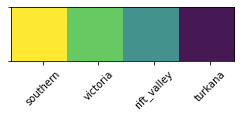

In [298]:
sns.palplot([c for c in raw_region_colors.values()])
ax = plt.gca()
ax.set_xticks(np.linspace(0.07, 3.07, 4))
ax.set_xticklabels([c for c in raw_region_colors.keys()], rotation=45);

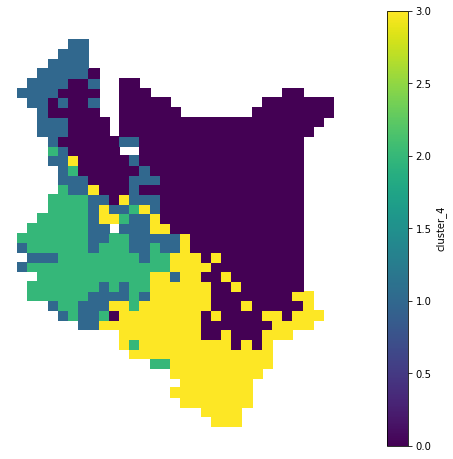

In [299]:
fig, ax = plt.subplots(figsize=(8, 8))

raw_cluster_da.where(~kenya_mask).plot(ax=ax)
ax.axis('off');

In [300]:
comparison_da = raw_cluster_da
raw_cluster_mask = raw_cluster_da

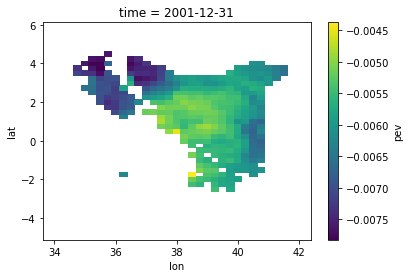

In [304]:
region='turkana'
dynamic_ds.where(raw_cluster_mask == raw_region_codes[region]).where(~kenya_mask)[variable].isel(time=0).plot()

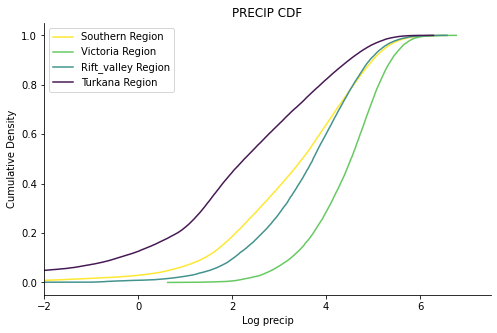

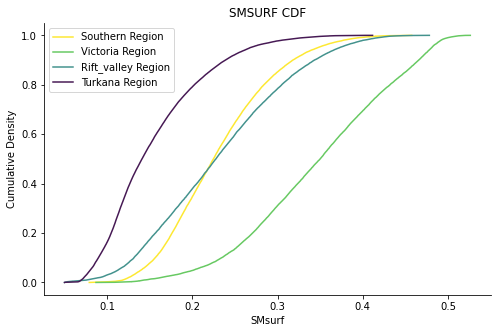

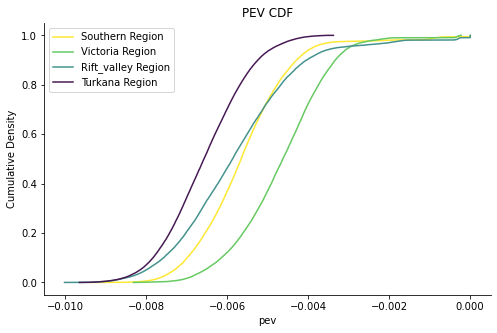

In [305]:
for ix, variable in enumerate(["precip", "SMsurf", "pev"]):
    fig, ax = plt.subplots(figsize=(8, 5))

    for region in [n for n in raw_region_codes.keys()]:
        # Extract the pixels from those regions 
        # data = a 1D array of the values from ds (no-nans)
        data = drop_nans_and_flatten(
            dynamic_ds
            .where(
                raw_cluster_mask == raw_region_codes[region]
            ).where(
                ~kenya_mask
            )[variable]
        )
        if variable == "precip":
#             data = np.log(data + 0.0001)
            ax.set_xlim(-2, 7.5)

        # plot cdf of the variable in that cluster
        ax = plot_cdf(
            data, ax=ax, 
            **dict(color=raw_region_colors[region], label=f'{region.capitalize()} Region')
        )
        ax.set_xlabel(variable if variable != "precip" else "Log precip")
        ax.set_ylabel('Cumulative Density')
        ax.set_title(f'{variable.upper()} CDF')
